In [ ]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
%matplotlib inline


# Data Preparation

In [ ]:
df = pd.read_csv('tracks.csv')
# working on a subset of the large dataset
df = df[df['popularity'] > 60]

In [ ]:
df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
8095,1LGqJ3nvxpVXDWpEzq4DJD,All of Me,65,181440,0,['Billie Holiday'],['1YzCsTRb22dQkh9lghPIrp'],1933,0.504,0.0644,2,-14.754,0,0.0408,0.972,0.000004,0.1740,0.4030,106.994,5
18549,0qB213IfGN0JXXm9aRjldF,Again (with The Mellomen),61,167907,0,"['Doris Day', 'The Mellomen']","['3ESG6pj6a0LvUKklENalT6', '548L4DXlt7N14Mhbfd...",1945,0.495,0.0209,3,-21.329,1,0.0348,0.981,0.000001,0.0753,0.1450,62.588,4
21549,6yhLR2sVn1IfsScVrR4ocr,"Whatever Will Be, Will Be (Que Sera, Sera) (wi...",62,123360,0,"['Doris Day', 'Frank DeVol & His Orchestra']","['3ESG6pj6a0LvUKklENalT6', '2N0Yx2ISFxGV0yt7xf...",1948,0.416,0.3410,9,-10.749,1,0.0391,0.864,0.000000,0.7240,0.7760,177.229,4
22549,5NGtFXVpXSvwunEIGeviY3,Gymnopédie No. 1,69,205867,0,"['Erik Satie', 'Philippe Entremont']","['459INk8vcC0ebEef82WjIK', '4x2fCu6MNErew0pb64...",1949,0.469,0.0128,7,-36.856,1,0.1190,0.994,0.937000,0.0941,0.3540,72.765,3
26499,6kf7ZCJjEbjZXikivKOsvJ,Claire de lune,62,347427,0,"['Claude Debussy', 'Alexis Weissenberg']","['1Uff91EOsvd99rtAupatMP', '2fxWL96h0S44PhEa9e...",1953,0.365,0.0100,1,-25.268,1,0.0519,0.995,0.924000,0.0584,0.0364,135.048,3


In [ ]:
data_w_genre = pd.read_csv('artists.csv')
data_w_genre.head()

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


In [ ]:
data_w_genre.rename(columns = {'name': 'artists', 'id': 'artists_id'}, inplace = True)

In [ ]:
#genre is an object which contains string
data_w_genre['genres'].values[0][0]

'['

In [ ]:
#extract genre into a list
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", str(x))])

In [ ]:
#checking
data_w_genre['genres_upd'].values[200][0]

'pinoy_hip_hop'

In [ ]:
#same for songs df
df['artists_upd_v1'] = df['artists'].apply(lambda x: re.findall(r"'([^']*)'", str(x)))

In [ ]:
df['artists_upd_v1'].values[0][0]

'Billie Holiday'

In [ ]:
#checking for this df
df[df['artists_upd_v1'].apply(lambda x: not x)].head(5)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_upd_v1
31509,2HUZVffVPXvqnrml0gXggp,Smokestack Lightnin',62,188400,0,"[""Howlin' Wolf""]",['0Wxy5Qka8BN9crcFkiAxSR'],1958-03-01,0.661,0.342,...,-16.361,0,0.0430,0.8440,0.000128,0.2600,0.588,146.118,4,[]
35501,4fQMGlCawbTkH9yPPZ49kP,Green Onions,69,176333,0,"[""Booker T. & the M.G.'s""]",['2vDV0T8sxx2ENnKXds75e5'],1962,0.816,0.514,...,-8.741,1,0.0339,0.7670,0.949000,0.0899,0.912,136.837,4,[]
35514,6KKcey1w86oP0qxN8frbfD,Green Onions - 45 Version,61,167385,0,"[""Booker T. & the M.G.'s""]",['2vDV0T8sxx2ENnKXds75e5'],1962,0.788,0.380,...,-15.179,1,0.0346,0.8110,0.906000,0.1020,0.892,138.205,4,[]
38509,1udKn1oNKYQSQ9OmiIWCMu,Do You Believe in Magic?,69,125827,0,"[""The Lovin' Spoonful""]",['7CCn4PFRRRZF127jtCBAUe'],1965-11,0.553,0.738,...,-7.963,1,0.0457,0.2130,0.000000,0.3390,0.759,138.602,4,[]
39542,7AzFID6u1b3zIWbd9pb8Dk,Summer in the City - Remastered,65,160307,0,"[""The Lovin' Spoonful""]",['7CCn4PFRRRZF127jtCBAUe'],1966-11,0.423,0.681,...,-9.756,1,0.0397,0.0592,0.000177,0.0889,0.559,110.461,4,[]


In [ ]:
#artists enclosed in full quotes not handled
df['artists_upd_v2'] = df['artists'].apply(lambda x: re.findall('\"(.*?)\"',str(x)))
df['artists_upd'] = np.where(df['artists_upd_v1'].apply(lambda x: not x), df['artists_upd_v2'], df['artists_upd_v1'])

In [ ]:
#checking for this df
df[df['artists_upd_v1'].apply(lambda x: not x)].head(5)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_upd_v1,artists_upd_v2,artists_upd
31509,2HUZVffVPXvqnrml0gXggp,Smokestack Lightnin',62,188400,0,"[""Howlin' Wolf""]",['0Wxy5Qka8BN9crcFkiAxSR'],1958-03-01,0.661,0.342,...,0.0430,0.8440,0.000128,0.2600,0.588,146.118,4,[],[Howlin' Wolf],[Howlin' Wolf]
35501,4fQMGlCawbTkH9yPPZ49kP,Green Onions,69,176333,0,"[""Booker T. & the M.G.'s""]",['2vDV0T8sxx2ENnKXds75e5'],1962,0.816,0.514,...,0.0339,0.7670,0.949000,0.0899,0.912,136.837,4,[],[Booker T. & the M.G.'s],[Booker T. & the M.G.'s]
35514,6KKcey1w86oP0qxN8frbfD,Green Onions - 45 Version,61,167385,0,"[""Booker T. & the M.G.'s""]",['2vDV0T8sxx2ENnKXds75e5'],1962,0.788,0.380,...,0.0346,0.8110,0.906000,0.1020,0.892,138.205,4,[],[Booker T. & the M.G.'s],[Booker T. & the M.G.'s]
38509,1udKn1oNKYQSQ9OmiIWCMu,Do You Believe in Magic?,69,125827,0,"[""The Lovin' Spoonful""]",['7CCn4PFRRRZF127jtCBAUe'],1965-11,0.553,0.738,...,0.0457,0.2130,0.000000,0.3390,0.759,138.602,4,[],[The Lovin' Spoonful],[The Lovin' Spoonful]
39542,7AzFID6u1b3zIWbd9pb8Dk,Summer in the City - Remastered,65,160307,0,"[""The Lovin' Spoonful""]",['7CCn4PFRRRZF127jtCBAUe'],1966-11,0.423,0.681,...,0.0397,0.0592,0.000177,0.0889,0.559,110.461,4,[],[The Lovin' Spoonful],[The Lovin' Spoonful]


In [ ]:
#need to create own song identifier because there are duplicates of the same song with different ids
df['artists_song'] = df.apply(lambda row: row['artists_upd'][0]+str(row['name']),axis = 1)

df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [ ]:
df[df['name']=='Adore You']

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
86217,5AnCLGg35ziFOloEnXK4uu,Adore You,71,278747,0,['Miley Cyrus'],['5YGY8feqx7naU7z4HrwZM6'],2013-10-04,0.583,0.655,...,0.1110,0.000004,0.113,0.201,119.759,4,[Miley Cyrus],[],[Miley Cyrus],Miley CyrusAdore You
91884,3jjujdWJ72nww5eGnfs2E7,Adore You,88,207133,0,['Harry Styles'],['6KImCVD70vtIoJWnq6nGn3'],2019-12-13,0.676,0.771,...,0.0237,0.000007,0.102,0.569,99.048,4,[Harry Styles],[],[Harry Styles],Harry StylesAdore You
92524,1M4qEo4HE3PRaCOM7EXNJq,Adore You,74,207133,0,['Harry Styles'],['6KImCVD70vtIoJWnq6nGn3'],2019-12-06,0.676,0.771,...,0.0237,0.000007,0.102,0.569,99.048,4,[Harry Styles],[],[Harry Styles],Harry StylesAdore You


In [ ]:
#remove duplicates
df.drop_duplicates('artists_song',inplace = True)

In [ ]:
df[df['name']=='Adore You']

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
86217,5AnCLGg35ziFOloEnXK4uu,Adore You,71,278747,0,['Miley Cyrus'],['5YGY8feqx7naU7z4HrwZM6'],2013-10-04,0.583,0.655,...,0.1110,0.000004,0.113,0.201,119.759,4,[Miley Cyrus],[],[Miley Cyrus],Miley CyrusAdore You
91884,3jjujdWJ72nww5eGnfs2E7,Adore You,88,207133,0,['Harry Styles'],['6KImCVD70vtIoJWnq6nGn3'],2019-12-13,0.676,0.771,...,0.0237,0.000007,0.102,0.569,99.048,4,[Harry Styles],[],[Harry Styles],Harry StylesAdore You


In [ ]:
artists_exploded = df[['artists_upd','id']].explode('artists_upd')

artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [ ]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='6KuQTIu1KoTTkLXKrwlLPV']

,artists_upd,id,artists_id,followers,genres,artists,popularity,genres_upd


In [ ]:
#group by on song ids
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()


In [ ]:
#return a flattened genre_list
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [ ]:
artists_genres_consolidated

,id,genres_upd,consolidates_genre_lists
0,001UkMQHw4zXfFNdKpwXAF,"[[contemporary_country, country, country_road,...","[contemporary_country, country_rock, country_r..."
1,003FTlCpBTM4eSqYSWPv4H,"[[modern_rock, neo_mellow, pop_punk, pop_rock,...","[pop_rock, post-teen_pop, pop_punk, neo_mellow..."
2,005Dlt8Xaz3DkaXiRJgdiS,"[[cantautor, latin, latin_arena_pop, latin_pop...","[cantautor, tropical, latin_pop, rock_en_espan..."
3,006pMMCuRo2TFjh8sNGSov,"[[brazilian_rock, hard_rock_brasileiro, rock_a...","[rock_nacional_brasileiro, brazilian_rock, har..."
4,006u4CXVO2cusq08RrMElQ,[[]],[]
...,...,...,...
22813,7zv0i1f8kTy8hPapkm28kz,[[]],[]
22814,7zwn1eykZtZ5LODrf7c0tS,"[[modern_alternative_rock, modern_rock, pop, s...","[modern_rock, modern_alternative_rock, shimmer..."
22815,7zx1i0jGcFwMBurajgKlO7,[[dutch_edm]],[dutch_edm]
22816,7zxRMhXxJMQCeDDg0rKAVo,"[[canadian_hip_hop, melodic_rap, pop_rap, rap,...","[rap, canadian_hip_hop, canadian_contemporary_..."


In [ ]:
df = df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

# Feature Engineering

In [ ]:
df.tail()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists
22917,706ZrLifsm0nwlucKr4kQg,Like Me (feat. iann dior),73,167147,1,"['$NOT', 'iann dior']","['5IbEL2xjRtKsunfmsahLuO', '6ASri4ePR7RlsvIQgW...",2020-10-30,0.902,0.462,...,0.000002,0.0940,0.646,103.984,4,"[$NOT, iann dior]",[],"[$NOT, iann dior]",$NOTLike Me (feat. iann dior),"[underground_hip_hop, florida_rap, dark_trap, ..."
22918,0j8ppsOOawdPCJnSTcXgOy,GOSHA,78,120000,1,['$NOT'],['5IbEL2xjRtKsunfmsahLuO'],2020-03-06,0.847,0.448,...,0.000013,0.3250,0.488,79.975,4,[$NOT],[],[$NOT],$NOTGOSHA,"[dark_trap, vapor_trap, florida_rap, undergrou..."
22919,2VnNaJFGInEJ0R5GkSQ7IP,Se Picó,66,139431,0,"['#TocoParaVos', 'El Reja', 'Marka Akme']","['4PdggFNYwGfjRfkdG5OfES', '7HSeegdmjLYRJpkOYI...",2021-01-14,0.620,0.590,...,0.000000,0.0693,0.863,180.143,4,"[#TocoParaVos, El Reja, Marka Akme]",[],"[#TocoParaVos, El Reja, Marka Akme]",#TocoParaVosSe Picó,"[cumbia_villera, cumbia_pop]"
22920,2LP2uDQQ7eLMcUVE4aOpAV,Crush on You (feat. Lil' Cease) - Remix,61,275947,0,"[""Lil' Kim"", ""Lil' Cease""]","['5tth2a3v0sWwV1C7bApBdX', '6V4zyNV40Zyu5MGlhD...",1997-06-30,0.748,0.693,...,0.000000,0.1230,0.768,88.802,4,"[ Kim"", ""Lil]","[Lil' Kim, Lil' Cease]","[ Kim"", ""Lil]","Kim"", ""LilCrush on You (feat. Lil' Cease) - R...",NaN
22921,4s0o8TJHfX9LLHa0umnOzT,Sunshine (feat. Lea),64,225173,1,"[""Lil' Flip"", 'Lea']","['4Q5sPmM8j4SpMqL4UA1DtS', '4tAhhPPEWcszcMjhYR...",2004-03-30,0.814,0.387,...,0.000000,0.1310,0.792,93.961,4,"[ Flip"", ]",[Lil' Flip],"[ Flip"", ]","Flip"", Sunshine (feat. Lea)",NaN


In [ ]:
#one-hot encode year variable
df['year'] = df['release_date'].apply(lambda x: x.split('-')[0])

float_cols = df.dtypes[df.dtypes == 'float64'].index.values

In [ ]:
#one-hot encode popularity variable
ohe_cols = 'popularity'

df['popularity'].describe()

count    22922.0000
mean        67.1896
std          5.5609
min         61.0000
25%         63.0000
50%         66.0000
75%         70.0000
max         99.0000
Name: popularity, dtype: float64

In [ ]:
# create 5 point buckets for popularity 
df['popularity_exp'] = df['popularity'].apply(lambda x: int(x/5))

In [ ]:
# tfidf can't handle nulls so fill any null values with an empty list
df['consolidates_genre_lists'] = df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,valence,tempo,time_signature,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,year,popularity_exp
0,47O6EPP78iQOOma2OVsYwS,星辰大海,61,207857,0,['黄霄雲'],['4vcc1VAbvzJjbMTsPYL6OU'],2021-01-15,0.303,0.550,...,0.161,167.874,4,[黄霄雲],[],[黄霄雲],黄霄雲星辰大海,[],2021,12
1,0KWnRv3wxjltYVB3MqjNd2,Without You,65,175500,0,['高爾宣 OSN'],['4TcOznbEZBqev21LzAH4KE'],2019-04-30,0.669,0.698,...,0.286,80.003,4,[高爾宣 OSN],[],[高爾宣 OSN],高爾宣 OSNWithout You,"[taiwan_hip_hop, taiwan_pop, mandopop]",2019,13
2,0q1FMCm6hZhyPomad3LQES,So Bad,63,172119,0,['高爾宣 OSN'],['4TcOznbEZBqev21LzAH4KE'],2020-08-10,0.742,0.666,...,0.559,118.011,4,[高爾宣 OSN],[],[高爾宣 OSN],高爾宣 OSNSo Bad,"[taiwan_hip_hop, taiwan_pop, mandopop]",2020,12
3,1dGF5ymTyBB2ZmOypkeU1F,veil,68,209636,0,['須田景凪'],['5dWE3G7COO82G6vRy2Hpum'],2019-08-21,0.559,0.873,...,0.797,150.055,4,[須田景凪],[],[須田景凪],須田景凪veil,[japanese_teen_pop],2019,13
4,3IP4qSMfGeqI2XqHFf25sj,芒种,65,216000,0,"['音阙诗听', '赵方婧']","['6JZIgN9gEgNSS8lY5pmwbx', '4P2x3pFDSDXPLOKWSq...",2019-06-06,0.781,0.656,...,0.548,99.981,4,"[音阙诗听, 赵方婧]",[],"[音阙诗听, 赵方婧]",音阙诗听芒种,"[mainland_chinese_pop, chinese_viral_pop, zhon...",2019,13


To create OHE features 

In [ ]:
#simple function to create OHE features
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [ ]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_exp','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [ ]:
complete_feature_set = create_feature_set(df, float_cols=float_cols)
complete_feature_set.head()

,genre|432hz,genre|_brasileira,genre|_hip_hop,genre|a_cappella,genre|abstract_beats,genre|accordion,genre|acid_house,genre|acid_jazz,genre|acid_rock,genre|acid_trance,...,year|2013,year|2014,year|2015,year|2016,year|2017,year|2018,year|2019,year|2020,year|2021,id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,47O6EPP78iQOOma2OVsYwS
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0KWnRv3wxjltYVB3MqjNd2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0q1FMCm6hZhyPomad3LQES
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,1dGF5ymTyBB2ZmOypkeU1F
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,3IP4qSMfGeqI2XqHFf25sj


In [ ]:
complete_feature_set.to_csv('complete_feature.csv')
df.to_csv('songs.csv')

# Recommendation Model

In [ ]:
!pip install spotipy

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 138 kB 7.7 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
#set up the client id and secret key variables
cid = "70e1036d72f94384a09bb3f99878398b"
secret = "542d003637fe428dae96ae94c329ffef"

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
def fetch_tracks(id, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        id: id of the playlist you'd like to pull from the spotify API
        df (pandas dataframe): spotify dataframe
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()

    for ix, i in enumerate(sp.playlist(id)['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [ ]:
playlist_link = "https://open.spotify.com/playlist/3vdYDhTPS1399eLUzsrPJE?si=7369f29e2f824c32"

playlist_URI = playlist_link.split("/")[-1].split("?")[0]

In [ ]:
playlist_test_EDM = fetch_tracks(playlist_URI, df)
playlist_test_EDM

,artist,name,id,url,date_added
49,Calvin Harris,My Way,1vvNmPOiUuyCbgWmtc6yfm,https://i.scdn.co/image/ab67616d00001e028d12bc...,2022-04-18 03:36:09+00:00
48,Calvin Harris,This Is What You Came For (feat. Rihanna),0azC730Exh71aQlOt9Zj3y,https://i.scdn.co/image/ab67616d00001e02d9aa52...,2022-04-18 03:34:22+00:00
46,Kygo,Stole the Show,5masKPHeAOVNgxdLebIcK7,https://i.scdn.co/image/ab67616d00001e0235590c...,2022-04-18 03:30:24+00:00
44,Calvin Harris,I Need Your Love (feat. Ellie Goulding),05SBRd4fXgn8FX7bf8BCAE,https://i.scdn.co/image/ab67616d00001e02dcef90...,2022-04-18 02:50:56+00:00
43,Calvin Harris,Summer,6YUTL4dYpB9xZO5qExPf05,https://i.scdn.co/image/ab67616d00001e02063c04...,2022-04-11 05:26:51+00:00
38,Jonas Blue,Fast Car,1SN1vSPsr4V4tIUTR3s8YW,https://i.scdn.co/image/ab67616d00001e025b6bcc...,2019-10-16 04:14:55+00:00
36,Steve Aoki,Delirious (Boneless) (feat. Kid Ink),2SSFvQBwsxeazzo7z5l9gD,https://i.scdn.co/image/ab67616d00001e0258dad1...,2019-10-16 04:09:01+00:00
35,DJ Snake,Let Me Love You,0lYBSQXN6rCTvUZvg9S0lU,https://i.scdn.co/image/ab67616d00001e02212d77...,2019-10-16 04:08:24+00:00
34,Coldplay,A Sky Full of Stars,0FDzzruyVECATHXKHFs9eJ,https://i.scdn.co/image/ab67616d00001e02f864bc...,2019-10-16 04:07:25+00:00
33,DJ Snake,You Know You Like It,57kR5SniQIbsbVoIjjOUDa,https://i.scdn.co/image/ab67616d00001e02567a71...,2019-10-16 04:07:21+00:00


In [ ]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

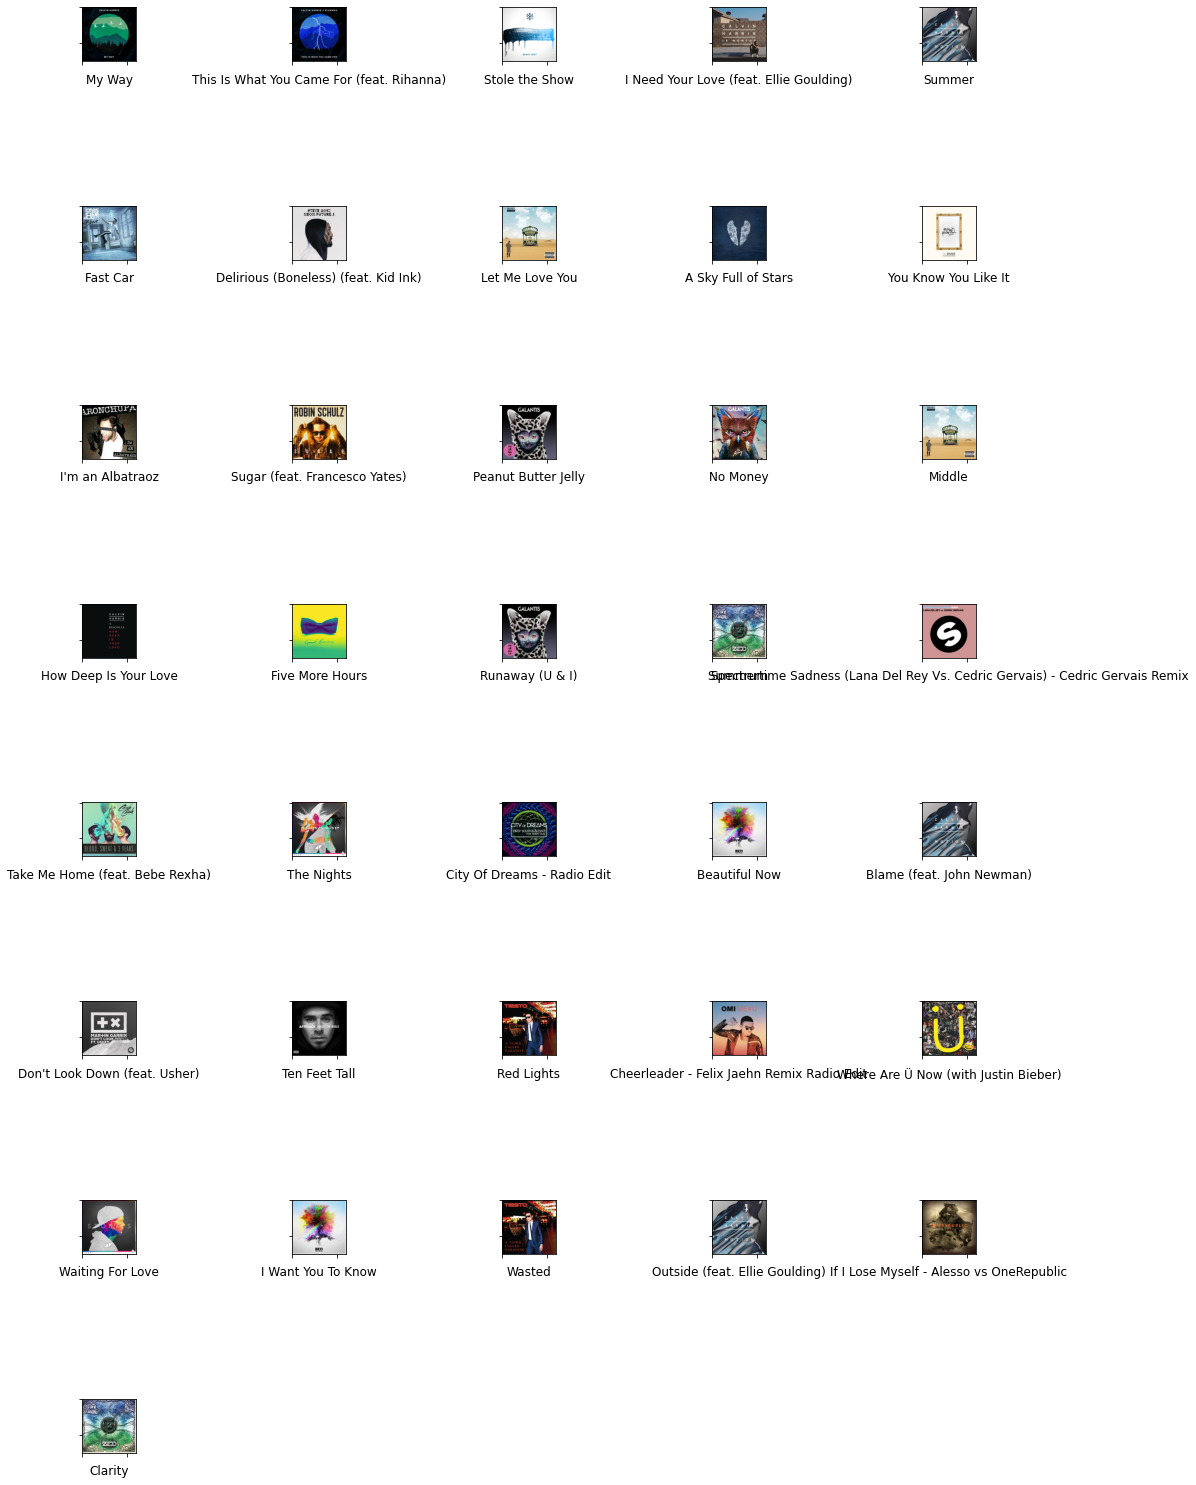

In [ ]:
visualize_songs(playlist_test_EDM)

## Generate playlist vector

In [ ]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [ ]:
complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM = generate_playlist_feature(complete_feature_set, playlist_test_EDM, 1.09)
complete_feature_set_playlist_vector_EDM.shape

(2386,)

## Generate Recommendations

In [ ]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [ ]:
edm_top40 = generate_playlist_recos(df, complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM)

In [ ]:
edm_top40

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,time_signature,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,year,popularity_exp,sim,url
19373,1gihuPhrLraKYrJMAEONyc,Feel So Close - Radio Edit,82,206413,0,['Calvin Harris'],['7CajNmpbOovFoOoasH2HaY'],2012-10-29,0.707,0.924,...,4,[Calvin Harris],[],[Calvin Harris],Calvin HarrisFeel So Close - Radio Edit,"[edm, uk_dance, pop, dance_pop, pop_dance, ele...",2012,16,0.824818,https://i.scdn.co/image/ab67616d00001e02dcef90...
19358,24LS4lQShWyixJ0ZrJXfJ5,Sweet Nothing (feat. Florence Welch),73,212560,0,"['Calvin Harris', 'Florence Welch']","['7CajNmpbOovFoOoasH2HaY', '0IROOdQ2fQUcoaEPqt...",2012-10-29,0.573,0.929,...,4,"[Calvin Harris, Florence Welch]",[],"[Calvin Harris, Florence Welch]",Calvin HarrisSweet Nothing (feat. Florence Welch),"[edm, uk_dance, uk_pop, pop, dance_pop, pop_da...",2012,14,0.793203,https://i.scdn.co/image/ab67616d00001e02dcef90...
19371,5itOtNx0WxtJmi1TQ3RuRd,Giant (with Rag'n'Bone Man),78,229184,0,"['Calvin Harris', ""Rag'n'Bone Man""]","['7CajNmpbOovFoOoasH2HaY', '4f9iBmdUOhQWeP7dcA...",2019-01-11,0.807,0.887,...,4,"[Calvin Harris, n]",[Rag'n'Bone Man],"[Calvin Harris, n]",Calvin HarrisGiant (with Rag'n'Bone Man),"[edm, uk_dance, pop, dance_pop, pop_dance, ele...",2019,15,0.785438,https://i.scdn.co/image/ab67616d00001e02a9a9d8...
19368,4wkQmYpAaMe41Rc3sYZ7Vz,Let's Go (feat. Ne-Yo),67,232800,0,"['Calvin Harris', 'Ne-Yo']","['7CajNmpbOovFoOoasH2HaY', '21E3waRsmPlU7jZsS1...",2012-10-29,0.710,0.882,...,4,"[Calvin Harris, Ne-Yo]",[],"[Calvin Harris, Ne-Yo]",Calvin HarrisLet's Go (feat. Ne-Yo),"[edm, uk_dance, urban_contemporary, r&b, pop, ...",2012,13,0.781293,https://i.scdn.co/image/ab67616d00001e02dcef90...
3831,3EmmCZoqpWOTY1g2GBwJoR,Just Hold On,68,198774,0,"['Steve Aoki', 'Louis Tomlinson']","['77AiFEVeAVj2ORpC85QVJs', '57WHJIHrjOE3iAxpih...",2016-12-10,0.647,0.932,...,4,"[Steve Aoki, Louis Tomlinson]",[],"[Steve Aoki, Louis Tomlinson]",Steve AokiJust Hold On,"[edm, tropical_house, post-teen_pop, pop, danc...",2016,13,0.768351,https://i.scdn.co/image/ab67616d00001e0222e2ce...
4953,0P6AWOA4LG1XOctzaVu5tt,The Weekend - Funk Wav Remix,78,171806,0,"['SZA', 'Calvin Harris', 'Funk Wav']","['7tYKF4w9nC0nq9CsPZTHyP', '7CajNmpbOovFoOoasH...",2017-12-15,0.775,0.573,...,4,"[SZA, Calvin Harris, Funk Wav]",[],"[SZA, Calvin Harris, Funk Wav]",SZAThe Weekend - Funk Wav Remix,"[edm, uk_dance, r&b, pop, dance_pop, pop_rap, ...",2017,15,0.765770,https://i.scdn.co/image/ab67616d00001e02b19d1c...
13519,1rFMYAZxBoAKSzXI54brMu,You Don't Know Me,63,213947,1,"['Jax Jones', 'RAYE']","['4Q6nIcaBED8qUel8bBx6Cr', '5KKpBU5eC2tJDzf0wm...",2016-12-09,0.877,0.658,...,4,"[Jax Jones, RAYE]",[],"[Jax Jones, RAYE]",Jax JonesYou Don't Know Me,"[edm, uk_contemporary_r&b, tropical_house, uk_...",2016,12,0.760920,https://i.scdn.co/image/ab67616d00001e021d883d...
19374,1oHxIPqJyvAYHy0PVrDU98,Drinking from the Bottle (feat. Tinie Tempah),64,240347,0,"['Calvin Harris', 'Tinie Tempah']","['7CajNmpbOovFoOoasH2HaY', '0Tob4H0FLtEONHU1Mj...",2012-10-29,0.665,0.886,...,4,"[Calvin Harris, Tinie Tempah]",[],"[Calvin Harris, Tinie Tempah]",Calvin HarrisDrinking from the Bottle (feat. T...,"[edm, tropical_house, uk_dance, post-teen_pop,...",2012,12,0.759894,https://i.scdn.co/image/ab67616d00001e02dcef90...
19366,7ef4DlsgrMEH11cDZd32M6,One Kiss (with Dua Lipa),83,214847,0,"['Calvin Harris', 'Dua Lipa']","['7CajNmpbOovFoOoasH2HaY', '6M2wZ9GZgrQXHCFfjv...",2018-04-06,0.791,0.862,...,4,"[Calvin Harris, Dua Lipa]",[],"[Calvin Harris, Dua Lipa]",Calvin HarrisOne Kiss (with Dua Lipa),"[edm, uk_dance, uk_pop, pop, dance_pop, pop_da...",2018,16,0.759669,https://i.scdn.co/image/ab67616d00001e02d09f96...
5509,3t4HeVfURZ5DuqMWz0Cmqg,We Found Love,61,215227,0,"['Rihanna', 'Calvin Harris']","['5pKCCKE2ajJHZ9KAiaK11H', '7CajNmpbOovFoOoasH...",2012-07-18,0.734,0.766,...,4,"[Rihanna, Calvin Harris]",[],"[Rihanna, Calvin Harris]",RihannaWe Found L